<a href="https://colab.research.google.com/github/jweon96/etf-rebalancing-portfolio/blob/main/dynamic_rebalancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ── 패키지 및 한글 폰트 설치 ──
!pip install yfinance
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 시스템 폰트 캐시 갱신
!fc-cache -f -v

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

In [ ]:
# ── 라이브러리 임포트 & 한글 폰트 설정 ──
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.font_manager as fm
import pprint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_recall_curve
from functools import reduce

# 1) 폰트 파일 경로 지정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 2) Matplotlib에 폰트 등록
fm.fontManager.addfont(font_path)

# 3) 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 4) 한글 폰트 설정
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 동적 리밸런싱

## 1️⃣ 데이터 수집
yfinance를 사용해 SPY, TLT, GLD의 2020-01-01 ~ 2024-12-31 종가 데이터를 가져옵니다.
auto_adjust=True 옵션을 통해 배당 및 분할이 반영된 가격을 사용합니다.

In [ ]:
# 설정
tickers = ['SPY', 'TLT', 'GLD']
start_date = '2020-01-01'
end_date = '2024-12-31'

# 데이터 수집
data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True
)['Close'].dropna()

# 데이터 확인
data.head()

[*********************100%***********************]  3 of 3 completed


Ticker,GLD,SPY,TLT
Date,,,
2020-01-02,143.949997,299.406372,117.133331
2020-01-03,145.860001,297.139252,118.937241
2020-01-06,147.389999,298.272858,118.261810
2020-01-07,147.970001,297.434296,117.680473
2020-01-08,146.860001,299.019318,116.902496


## 2️⃣ 동적 리밸런싱 개요

본 노트에서는 단순 정적 리밸런싱 규칙을 넘어,  
시장 상황에 따라 리밸런싱 조건을 유연하게 조정하는 동적 리밸런싱 전략을 설계합니다.

### 동적 리밸런싱의 필요성
- 정적 리밸런싱은 시장 변동성과 무관하게 고정된 규칙을 적용 → 비효율 가능
- 시장 변동성이 클 때는 리밸런싱 빈도를 낮추거나 밴드를 넓히고,  
  변동성이 작을 때는 보다 적극적으로 리밸런싱 필요

### 주요 접근 방법
1️⃣ **변동성 기반 동적 밴드**
- 최근 30일 변동성을 기준으로 밴드 폭을 동적으로 조정  
- 변동성 ↑ → 밴드 폭 ↑ (덜 민감)
- 변동성 ↓ → 밴드 폭 ↓ (더 민감)

2️⃣ **ML 기반 리밸런싱 트리거**
- 과거 수익률, 변동성, 상관계수 등을 feature로 사용
- 간단한 의사결정 모델로 리밸런싱 여부 결정

## 3️⃣ 변동성 기반 동적 밴드 리밸런싱

동적 밴드 리밸런싱은 최근 시장의 변동성을 반영하여  
리밸런싱의 민감도를 자동으로 조정하는 전략입니다.

### 전략 개요
- 기준: 최근 30일간 포트폴리오 수익률의 변동성
- 밴드 폭 계산: 변동성 × 조정계수 (예: 1.5, 2.0)
- 각 ETF의 목표 비중과 현재 비중이 밴드 바깥으로 벗어나면 리밸런싱 실행

### 3-1️⃣ 비중 정의  
- **포트폴리오 목표 비중**  
  - SPY: 60%  
  - TLT: 30%  
  - GLD: 10%

In [ ]:
# 포트폴리오 목표 비중
weights = {'SPY': 0.6, 'TLT': 0.3, 'GLD': 0.1}

### 3-2️⃣ 포트폴리오 수익률 계산

- **데이터 준비**  
  - `data.pct_change().dropna()` 로 일간 수익률 계산  
- **포트폴리오 수익률**  
  - 정적 비중(`weights`)과 내적(dot) 수행  
- **결과**  
  - `portfolio_returns` 시리즈에 저장

In [ ]:
# 가격 데이터(data)에서 일간 수익률 계산
returns_df = data.pct_change().dropna()

# 정적 비중 기준 포트폴리오 수익률 시리즈
portfolio_returns = returns_df.dot(pd.Series(weights))

### 3-3️⃣ 변동성 및 동적 밴드 계산

- **변동성 계산**  
  - `returns.rolling(window=30).std()` 로 30일 이동 표준편차(Volatility) 산출  
- **밴드 산식**  
  - `Band = base_band + multiplier × volatility`  
  - 예: `base_band=3%`, `multiplier=2.0`  
- **결측치 보완**  
  > 첫 30일간 volatility가 NaN이므로 `bfill()`로 뒤쪽 값 채움

In [ ]:
def calculate_volatility(returns, window=30):
    """
    returns: pd.Series of daily returns
    window : lookback days for rolling volatility
    """
    return returns.rolling(window=window).std()

def get_dynamic_band(portfolio_returns, base_band=0.03, multiplier=2.0):
    """
    Calculate dynamic rebalancing band width.

    Band(width) = base_band + multiplier * rolling_volatility
    - base_band  : 최소 밴드 폭 (decimal, e.g. 0.03 = 3%)
    - multiplier : 변동성 민감도 조정 계수
    """
    vol = calculate_volatility(portfolio_returns, window=30)
    dynamic_band = base_band + multiplier * vol
    # 첫 30일은 vol이 NaN이므로, 뒤쪽 값으로 채워 초기 구간 보완
    return dynamic_band.bfill()

### 3-4️⃣ 밴드 시각화 및 해설

- **밴드 폭 시각화**  
  - 퍼센트 단위로 변환(소수 → %)  
  - 시간 흐름에 따른 밴드 폭 변화  

- **주요 포인트 어노테이션**  
  - COVID-19 충격기에 밴드 폭 급등  
  - 수직선·화살표·텍스트로 강조  

- **해설**  
  > 2020년 초 COVID-19 확산으로 변동성이 급격히 증가하며 밴드 폭이 약 **9%**까지 확대되었습니다.  
  > 이후 시장 안정화로 밴드는 다시 **4–6%** 수준으로 좁아졌습니다.

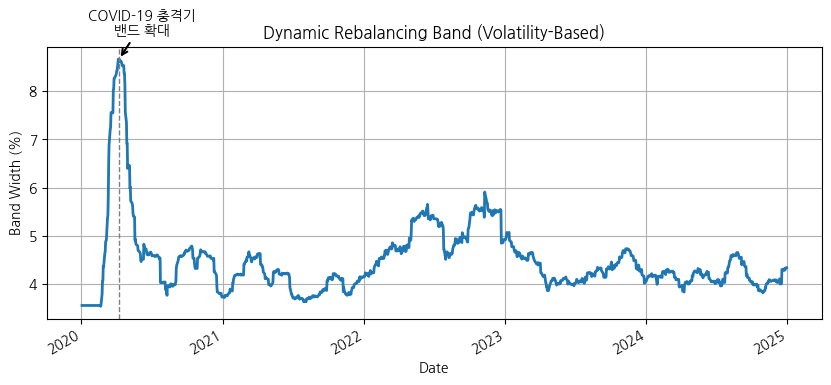

In [ ]:
# 동적 밴드 계산 (퍼센트 변환)
dynamic_band_series = get_dynamic_band(portfolio_returns, base_band=0.03, multiplier=2.0)
scaled_band = dynamic_band_series.mul(100)  # decimal → percent

# 최고 변동성 시점 자동 탐지
peak_date  = scaled_band.idxmax()
peak_value = scaled_band.max()

# 그래프
plt.figure(figsize=(10,4))
scaled_band.plot(color='tab:blue', linewidth=2)

# 수직 점선으로 최고점 강조
plt.axvline(peak_date, color='gray', linestyle='--', linewidth=1)

# 어노테이션
plt.annotate(
    'COVID-19 충격기\n밴드 확대',
    xy=(peak_date, peak_value),
    xytext=(peak_date + pd.Timedelta(days=60), peak_value + 0.5),
    arrowprops=dict(arrowstyle='->', lw=1.5),
    fontsize=10,
    fontweight='bold',
    ha='center'
)

plt.title('Dynamic Rebalancing Band (Volatility-Based)')
plt.ylabel('Band Width (%)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

## 4️⃣ 동적 리밸런싱 시뮬레이션

이제 3️⃣에서 계산한 **동적 밴드**를 실제 리밸런싱에 적용해 포트폴리오 가치를 시뮬레이션합니다.  
- **리밸런싱 룰**:  
  - 매 거래일마다 `|현재비중 − 목표비중| > 동적밴드` 이면 리밸런싱  
  - 거래비용 `cost_rate = 0.1%` 반영  
- **출력**:  
  - `portfolio_dynamic` : 날짜별 포트폴리오 가치 시리즈  
  - `turnovers_dynamic` : 각 거래일별 매매금액(turnover) 리스트

In [ ]:
# 4-1️⃣ 시뮬레이션 함수 정의
def simulate_dynamic_band_rebalancing(data, weights, base_band=0.03, multiplier=2.0, cost_rate=0.001):
    """
    Dynamic volatility-based band rebalancing simulation.
    """
    initial_capital = 10_000.0
    prices = data.copy()
    first_prices = prices.iloc[0]
    shares = {t: initial_capital * w / first_prices[t] for t, w in weights.items()}

    portfolio_values = []
    turnovers = []

    # 1) 수익률 & volatility & band 계산
    returns = prices.pct_change().dropna()
    port_returns = returns.dot(pd.Series(weights))
    vol = port_returns.rolling(window=30).std()
    raw_band = base_band + multiplier * vol

    # 2) band_series 를 전체 dates 에 재색인하고 bfill
    band_series = raw_band.reindex(prices.index).bfill()

    # 3) 시뮬레이션
    for date, price_row in prices.iterrows():
        # 현재 포트폴리오 가치
        value = sum(shares[t] * price_row[t] for t in weights)
        portfolio_values.append(value)

        # 현재 비중
        current_weights = {t: (shares[t] * price_row[t]) / value for t in weights}
        band = band_series.loc[date]

        # 리밸런싱 조건
        if any(abs(current_weights[t] - w) > band for t, w in weights.items()):
            current_values = {t: shares[t] * price_row[t] for t in weights}
            target_values  = {t: value * weights[t] for t in weights}
            turnover = sum(abs(current_values[t] - target_values[t]) for t in weights)
            cost     = turnover * cost_rate
            value   -= cost
            turnovers.append(turnover)
            shares = {t: value * weights[t] / price_row[t] for t in weights}
        else:
            turnovers.append(0.0)

    return pd.Series(portfolio_values, index=prices.index), turnovers

In [ ]:
# 4-2️⃣ 시뮬레이션 실행
portfolio_dynamic, turnovers_dynamic = simulate_dynamic_band_rebalancing(
    data,
    weights,
    base_band=0.03,
    multiplier=2.0,
    cost_rate=0.001
)

In [ ]:
# 4-3️⃣ 결과 확인
print(f"Sample values:\n{portfolio_dynamic.head()}")
print(f"\nAverage turnover per day: ${np.mean(turnovers_dynamic):,.2f}")

Sample values:
Date
2020-01-02    10000.000000
2020-01-03    10014.037649
2020-01-06    10030.084390
2020-01-07    10002.419979
2020-01-08    10006.546834
dtype: float64

Average turnover per day: $8.15


## 5️⃣ 성과지표 계산

동적 밴드 리밸런싱 전략의 성과를 정량적으로 평가합니다.  
- **CAGR**: 연평균 복리수익률  
- **Sharpe Ratio**: 연환산 샤프비율 (무위험이자율 0 가정)  
- **Max Drawdown**: 최대 낙폭  
- **거래비용 요약**: 총 거래비용 및 연평균 거래비용

In [ ]:
# 1) 성과지표 함수 정의
def performance_metrics(ts):
    """
    ts : pd.Series of portfolio values indexed by date
    Returns dict with CAGR, Sharpe, Max Drawdown
    """
    # 기간(년)
    days = (ts.index[-1] - ts.index[0]).days
    years = days / 365.25

    # CAGR
    cagr = (ts.iloc[-1] / ts.iloc[0])**(1/years) - 1

    # 일간 수익률
    daily_ret = ts.pct_change().dropna()
    # Sharpe Ratio (무위험률 0)
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252)

    # 최대 낙폭
    running_max = ts.cummax()
    drawdowns = (ts - running_max) / running_max
    max_dd = drawdowns.min()

    return {
        'CAGR': cagr,
        'Sharpe': sharpe,
        'Max Drawdown': max_dd
    }

In [ ]:
# 2) 지표 계산
metrics_dynamic = performance_metrics(portfolio_dynamic)

In [ ]:
# 3) 거래비용 계산
cost_rate = 0.001  # 0.1%
total_cost_dynamic = np.sum(turnovers_dynamic) * cost_rate
years = (data.index[-1] - data.index[0]).days / 365.25
avg_cost_dynamic = total_cost_dynamic / years

In [ ]:
# 4) 출력
pp = pprint.PrettyPrinter(indent=2)

print("### Dynamic Band Strategy Performance ###")
pp.pprint(metrics_dynamic)

print(f"\nTotal Transaction Cost: ${total_cost_dynamic:,.2f}")
print(f"Average Annual Transaction Cost: ${avg_cost_dynamic:,.2f}")

### Dynamic Band Strategy Performance ###
{ 'CAGR': np.float64(0.08642959314033316),
  'Max Drawdown': -0.25292650254590493,
  'Sharpe': np.float64(0.6863972491048902)}

Total Transaction Cost: $10.25
Average Annual Transaction Cost: $2.05


## 6️⃣ 결과 시각화

동적 밴드 리밸런싱 전략의 **포트폴리오 가치**와 **일별 거래금액(turnover)** 을 시각화합니다.

- **포트폴리오 가치**: 시뮬레이션 기간 동안의 계좌 잔고 추이  
- **일별 거래금액**: 리밸런싱 발생일에 실제 매매된 금액 추이

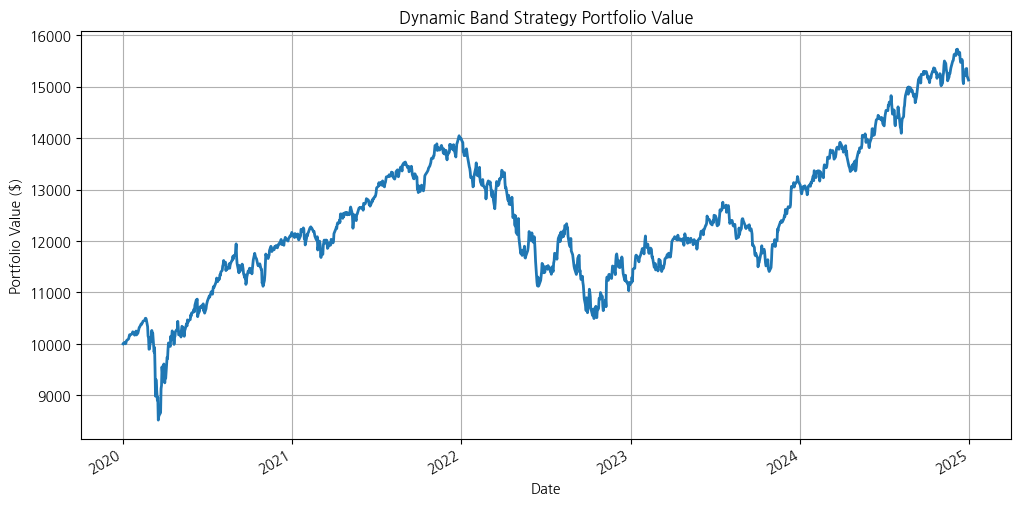

In [ ]:
# 1) 포트폴리오 가치 시각화
plt.figure(figsize=(12, 6))
portfolio_dynamic.plot(linewidth=2)
plt.title('Dynamic Band Strategy Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()

In [ ]:
# 2) 일별 거래금액(turnover) 시리즈 생성
turnover_series_dynamic = pd.Series(turnovers_dynamic, index=portfolio_dynamic.index)

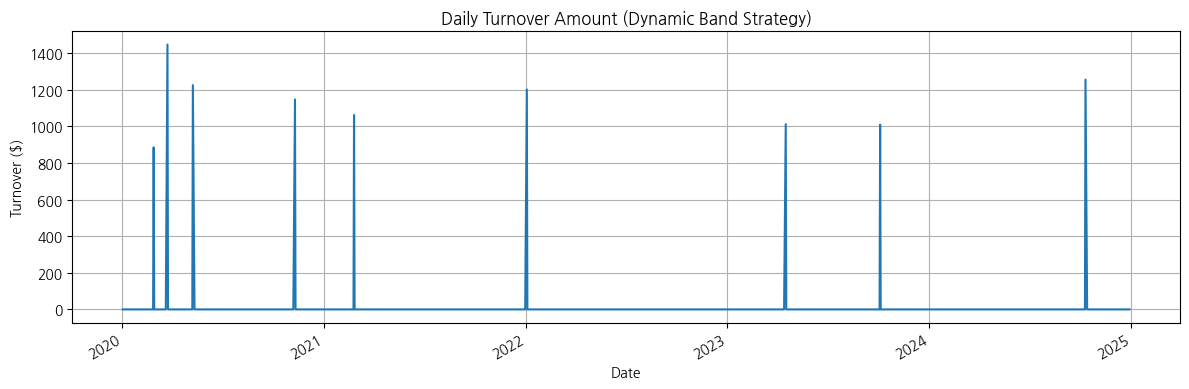

In [ ]:
# 3) 거래금액 시각화
plt.figure(figsize=(12, 4))
turnover_series_dynamic.plot(linewidth=1.5)
plt.title('Daily Turnover Amount (Dynamic Band Strategy)')
plt.xlabel('Date')
plt.ylabel('Turnover ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 7️⃣ ML 기반 리밸런싱 전략

### 7-1️⃣ 개요 및 접근 방법

📌 기존 리밸런싱 전략의 한계
- **정적 리밸런싱**은 고정된 규칙으로 실행되어, 시장 변화에 유연하게 대응하기 어렵습니다.
- **변동성 기반 동적 밴드 리밸런싱**은 변동성 기반 조정을 가능하게 했지만, 여전히 단일 변수(변동성)에 의존합니다.


🎯 ML 기반 전략의 목적
- **다양한 시장 지표**(수익률, 변동성, 상관관계 등)를 통합적으로 고려하여  
  "지금 리밸런싱을 해야 할까?"를 판단하는 **머신러닝 분류 모델**을 학습합니다.
- 이를 통해 **더 똑똑하고 유연한 리밸런싱 시점**을 포착하고자 합니다.



🛠️ 전략 개요

- **입력값 (Features)**:  
  최근 일정 기간의  
  → 수익률  
  → 변동성  
  → 자산 간 상관계수 등

- **출력값 (Label)**:  
  해당 날짜에 리밸런싱이 필요한가?  
  → `1`: 리밸런싱 수행  
  → `0`: 유지

- **모델**:  
  간단한 분류 모델  
  → `Random Forest Classifier` 또는 `Logistic Regression`

- **실행 방식**:  
  학습된 모델이 `1`을 예측한 날에만 리밸런싱을 수행합니다.



### 7-2️⃣ 라벨 생성 (Rebalancing 여부 판단 기준)

📌 라벨 정의

- 과거 **20영업일 누적수익률(`mom20`)**을 기준으로 **승자(최고 수익률 자산)**와 **패자(최저 수익률 자산)**를 결정합니다.

- 이후 향후 H영업일(10일) 누적수익률을 계산하여, 패자가 승자를 최소 θ(0.4%p) 이상 초과하면 → `1`(리밸런싱 필요), 그렇지 않으면 → `0`(유지)로 라벨링합니다.

⚙️ 구체적 절차

1. 승자·패자 결정

- `mom20.idxmax()` → 승자

- `mom20.idxmin()` → 패자

2. 향후 수익 계산

- `rets.shift(-1).rolling(H).sum()` 으로 다음 10영업일 누적수익률 계산

3. 역전 조건 판별

- `(패자 미래수익 - 승자 미래수익) > θ` → 1

- 그 외 → 0

4. NaN 제거 후 Feature 인덱스와 맞추기

💡 이 방식은 단순 변동성 기반 조건이 아니라, 승자·패자 역전 시그널을 기준으로 ML 모델이 학습할 **타겟(Label)**을 생성하는 방법입니다.

In [ ]:
data = data.sort_index().dropna()
rets = data.pct_change().dropna()

w = pd.Series({'SPY': 0.6, 'TLT': 0.3, 'GLD': 0.1})

features = pd.DataFrame(index=rets.index)

# 포트폴리오 모멘텀/변동성
features['port_ret_5']  = rets.dot(w).rolling(5).sum()
features['port_ret_20'] = rets.dot(w).rolling(20).sum()
features['port_vol_20'] = rets.dot(w).rolling(20).std()

# 자산 간 상관계수(30일)
features['corr_SPY_TLT'] = rets['SPY'].rolling(30).corr(rets['TLT'])
features['corr_SPY_GLD'] = rets['SPY'].rolling(30).corr(rets['GLD'])
features['corr_TLT_GLD'] = rets['TLT'].rolling(30).corr(rets['GLD'])

features = features.dropna()

In [ ]:
H, theta = 10, 0.004
mom20 = rets.rolling(20).sum()
fwd   = rets.shift(-1).rolling(H).sum()

# 유효한 날짜 필터링
valid_idx = mom20.dropna().index.intersection(fwd.dropna().index)
mom20_v = mom20.loc[valid_idx]
fwd_v   = fwd.loc[valid_idx]

# 승자·패자 결정
winner = mom20_v.idxmax(axis=1)
loser  = mom20_v.idxmin(axis=1)

# 미래 수익률 추출
fwd_w = pd.Series([fwd_v.loc[i, winner.loc[i]] for i in valid_idx], index=valid_idx)
fwd_l = pd.Series([fwd_v.loc[i, loser.loc[i]]  for i in valid_idx], index=valid_idx)

# 라벨 생성
label = ((fwd_l - fwd_w) > theta).astype(int)

# Feature와 라벨 동기화
common_idx = features.index.intersection(label.index)
X = features.loc[common_idx]
y = label.loc[common_idx]

In [ ]:
# ✅ 무결성 점검
print("X shape:", X.shape, "| y shape:", y.shape)
assert X.index.equals(y.index), "X와 y 인덱스가 다릅니다!"
print("Positive rate (y=1 비율):", y.mean().round(3))

# 결측치 최종 확인
print("X NaN count:", X.isna().sum().sum(), "| y NaN count:", y.isna().sum())

X shape: (1226, 6) | y shape: (1226,)
Positive rate (y=1 비율): 0.182
X NaN count: 0 | y NaN count: 0


### 7-3️⃣ 모델 학습 및 예측

🧪 1) 시간 순서 유지한 데이터 분할

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False
)

🌲 2) 두 가지 모델 학습 (RandomForest, Logistic)

In [ ]:
# Random Forest (클래스 불균형 보정)
rf_model = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=5,
    class_weight='balanced', random_state=42, n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Logistic + 스케일링 (클래스 불균형 보정)
logit_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=300, random_state=42)
)
logit_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=300,
                                    random_state=42))])

✅ 3) 평가 (ROC-AUC & 분류 리포트 @ 0.50)

In [ ]:
# 확률
rf_proba = rf_model.predict_proba(X_test)[:, 1]
lg_proba = logit_model.predict_proba(X_test)[:, 1]

# 0.50 기준 리포트
rf_pred50 = (rf_proba > 0.50).astype(int)
lg_pred50 = (lg_proba > 0.50).astype(int)

print("=== RandomForest @0.50 ===")
print(classification_report(y_test, rf_pred50, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, rf_proba))

print("\n=== Logistic @0.50 ===")
print(classification_report(y_test, lg_pred50, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, lg_proba))

=== RandomForest @0.50 ===
              precision    recall  f1-score   support

           0      0.830     0.992     0.904       255
           1      0.000     0.000     0.000        52

    accuracy                          0.824       307
   macro avg      0.415     0.496     0.452       307
weighted avg      0.689     0.824     0.751       307

ROC-AUC: 0.5162895927601809

=== Logistic @0.50 ===
              precision    recall  f1-score   support

           0      0.856     0.906     0.880       255
           1      0.351     0.250     0.292        52

    accuracy                          0.795       307
   macro avg      0.603     0.578     0.586       307
weighted avg      0.770     0.795     0.780       307

ROC-AUC: 0.6074660633484164


📊 4) 임계값 최적화 (F1 최대화 기준)

In [ ]:
def best_threshold_by_f1(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    i = np.nanargmax(f1)
    best_thr = thr[i] if i < len(thr) else 0.50  # 마지막 점 보정
    return best_thr, float(prec[i]), float(rec[i]), float(f1[i])

rf_thr, rf_p, rf_r, rf_f1 = best_threshold_by_f1(y_test, rf_proba)
lg_thr, lg_p, lg_r, lg_f1 = best_threshold_by_f1(y_test, lg_proba)

print(f"RF best thr={rf_thr:.3f} | P={rf_p:.3f} R={rf_r:.3f} F1={rf_f1:.3f}")
print(f"LG best  thr={lg_thr:.3f} | P={lg_p:.3f} R={lg_r:.3f} F1={lg_f1:.3f}")

RF best thr=0.158 | P=0.198 R=0.981 F1=0.329
LG best  thr=0.458 | P=0.279 R=0.596 F1=0.380


📌 5) 시뮬레이션용 예측 시리즈 생성 (7-4에서 사용)

In [ ]:
# F1 최적 임계값으로 0/1 신호 생성
rf_pred_series = pd.Series((rf_proba > rf_thr).astype(int), index=y_test.index, name="rf_signal")
lg_pred_series = pd.Series((lg_proba > lg_thr).astype(int), index=y_test.index, name="lg_signal")

### 7-4️⃣ 리밸런싱 실행 (ML 예측 기반 · 드리프트/거래비용 반영)

- 예측 시그널이 **1**인 날에만 리밸런싱을 수행합니다.  
- **매일 가중치 드리프트**를 반영하고, 리밸런싱 시점에 **turnover × cost_rate × 포트가치** 만큼 비용을 차감합니다.  
- 결과로 **포트폴리오 가치**, **일별 턴오버**, **일별 비용**을 반환합니다.

7-4-1) 시뮬레이션 함수 정의 (드리프트 + 비용 기록)

In [ ]:
def simulate_ml_rebalancing(data, weights, pred_series, cost_rate=0.001, initial=10_000.0):
    """
    pred_series=1인 날에만 리밸런싱. 매일 가중치가 수익으로 드리프트되도록 반영.
    반환: (portfolio_series, turnovers(list), costs(list))
    - turnover = Σ|w_current - w_target|  (비중 L1 거리)
    - cost($)   = turnover * cost_rate * 포트 가치 (당일)
    """
    # 날짜 동기화
    idx = data.index.intersection(pred_series.index)
    data = data.loc[idx].sort_index().copy()
    pred_series = pred_series.loc[idx].sort_index().astype(int)

    target_w = pd.Series(weights, dtype=float)
    cur_w = target_w.copy()
    port = pd.Series(index=data.index, dtype=float)
    port.iloc[0] = float(initial)

    turnovers, costs = [], []

    for i in range(1, len(data)):
        today, yesterday = data.index[i], data.index[i-1]

        # 1) 포트 가치 업데이트 (어제 비중으로 오늘 수익 반영)
        r_today = data.loc[today] / data.loc[yesterday] - 1.0
        port.iloc[i] = port.iloc[i-1] * (1.0 + (cur_w * r_today).sum())

        # 2) 가중치 드리프트 (오늘 수익 반영 후의 실제 비중)
        gross = cur_w * (1.0 + r_today)
        cur_w = gross / gross.sum()

        # 3) 트리거면 리밸런싱: turnover 계산 → 비용 차감 → 목표비중으로 세팅
        if pred_series.iloc[i] == 1:
            turnover = (cur_w - target_w).abs().sum()
            cost = turnover * cost_rate * port.iloc[i]
            port.iloc[i] -= cost
            cur_w = target_w.copy()

            turnovers.append(float(turnover))
            costs.append(float(cost))
        else:
            turnovers.append(0.0)
            costs.append(0.0)

    return port, turnovers, costs

7-4-2) 예측 시리즈 선택

In [ ]:
# 어떤 모델 신호를 사용할지 선택 (7-3에서 만든 것)
use_model = "LG"  # "RF" 로 바꿔도 됨

if use_model == "LG":
    pred_series = lg_pred_series.copy()
    model_name = "Logistic@F1thr"
elif use_model == "RF":
    pred_series = rf_pred_series.copy()
    model_name = "RandomForest@F1thr"
else:
    raise ValueError("use_model 은 'LG' 또는 'RF' 중 하나여야 합니다.")

7-4-3) 시뮬레이션 실행 & 요약

In [ ]:
portfolio_ml, turnovers_ml, costs_ml = simulate_ml_rebalancing(
    data=data,
    weights=weights,
    pred_series=pred_series,
    cost_rate=cost_rate,
    initial=initial_capital
)

# 요약
idx = portfolio_ml.index
years = (idx[-1] - idx[0]).days / 365.25
signals = int(pred_series.loc[idx].sum())
total_cost = float(np.sum(costs_ml))
avg_cost_y = (total_cost / years) if years > 0 else np.nan

print(f"[{model_name}]")
print(f"- 기간: {idx[0].date()} ~ {idx[-1].date()} ({years:.2f}년)")
print(f"- 신호 개수: {signals:,d}")
print(f"- 총 거래비용: ${total_cost:,.4f}")
print(f"- 연평균 거래비용: ${avg_cost_y:,.4f}")
print(f"- 리밸런싱 발생일 수: {(np.array(turnovers_ml)>0).sum()} / {len(turnovers_ml)}")

[Logistic@F1thr]
- 기간: 2023-10-10 ~ 2024-12-27 (1.22년)
- 신호 개수: 110
- 총 거래비용: $7.6023
- 연평균 거래비용: $6.2539
- 리밸런싱 발생일 수: 109 / 306


7-4-4) 빠른 시각화 (단독)

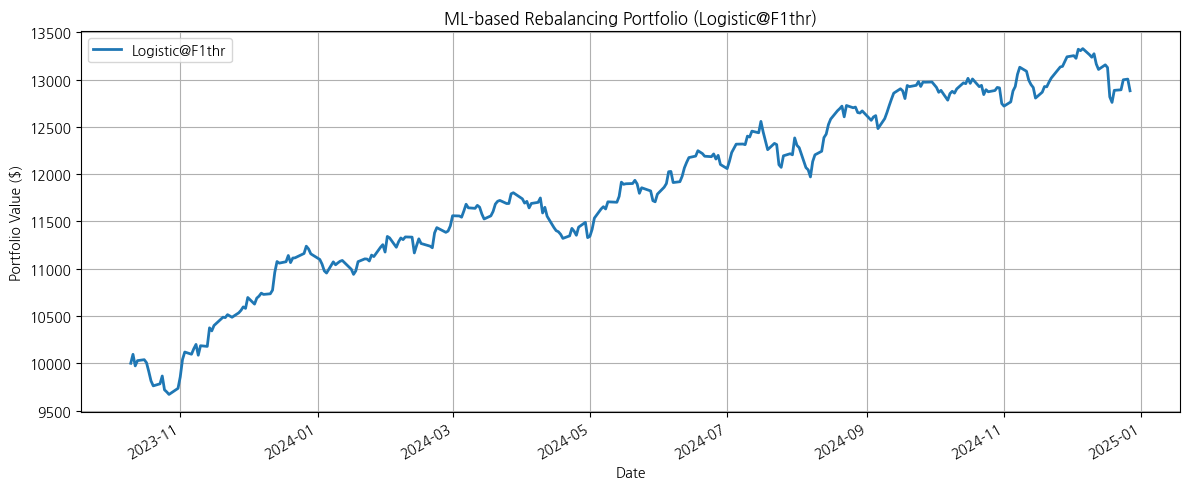

In [ ]:
plt.figure(figsize=(12,5))
portfolio_ml.plot(label=model_name, linewidth=2)
plt.title(f"ML-based Rebalancing Portfolio ({model_name})")
plt.ylabel("Portfolio Value ($)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

### 7-5️⃣ ML 기반 전략 vs 기존 전략 성과 비교

- 공정성을 위해 **공통 기간**으로 정렬해 비교합니다.  
- 표(CAGR/Sharpe/MaxDD/Vol)와 **정규화 누적가치**·**드로우다운** 그래프를 제공합니다.

7-5-1) 비교 대상 준비 & 기간 정렬

In [ ]:
# 1) 비교 후보 등록 (존재하는 것만 추가)
candidates = {"ML-based": portfolio_ml}

# ↓ 아래 try 블록들은 있는 것만 자동 포함 (없어도 에러 없음)
try: candidates["Dynamic Band"] = portfolio_dynamic
except NameError: pass
try: candidates["Band 5% + Cost"] = portfolio_band5_cost
except NameError: pass
try: candidates["Band 10% + Cost"] = portfolio_band10_cost
except NameError: pass
try: candidates["Annual Only + Cost"] = portfolio_annual_cost
except NameError: pass
try: candidates["Buy & Hold"] = portfolio_buy_hold
except NameError: pass

# 2) 공정 비교: 공통 기간 교집합만 사용
series_list = [s.dropna() for s in candidates.values()]
common_idx = reduce(lambda a,b: a.intersection(b.index), series_list, series_list[0].index)

aligned = {name: s.loc[common_idx].dropna() for name, s in candidates.items()}

print("비교 대상:", list(aligned.keys()))
print("비교 구간:", common_idx[0].date(), "~", common_idx[-1].date(), f"({(common_idx[-1]-common_idx[0]).days/365.25:.2f}년)")

비교 대상: ['ML-based', 'Dynamic Band']
비교 구간: 2023-10-10 ~ 2024-12-27 (1.22년)


7-5-2) 성과 지표 계산 (CAGR / Vol / Sharpe / MaxDD)

In [ ]:
def perf_metrics(ts: pd.Series) -> dict:
    ts = ts.dropna()
    years = (ts.index[-1] - ts.index[0]).days / 365.25
    daily = ts.pct_change().dropna()
    cagr = (ts.iloc[-1] / ts.iloc[0])**(1/years) - 1 if years > 0 else np.nan
    vol  = daily.std() * np.sqrt(252) if len(daily) else np.nan
    sharpe = (daily.mean() / daily.std()) * np.sqrt(252) if daily.std() not in (0, np.nan) else np.nan
    mdd = ((ts / ts.cummax()) - 1).min()  # 음수값
    return {"CAGR": cagr, "Volatility": vol, "Sharpe": sharpe, "Max Drawdown": mdd}

cost_summaries = {}
try:
    total_cost_ml = float(np.sum(costs_ml))
    years = (aligned["ML-based"].index[-1] - aligned["ML-based"].index[0]).days / 365.25
    avg_cost_ml   = total_cost_ml / years if years > 0 else np.nan
    cost_summaries["ML-based"] = {"TotalCost($)": total_cost_ml, "AvgAnnualCost($)": avg_cost_ml}
except Exception:
    pass

# 각 전략 성과표
rows = {}
for name, ts in aligned.items():
    rows[name] = perf_metrics(ts)

perf_df = pd.DataFrame(rows).T

# 비용/신호 수 합치기
try:
    perf_df.loc["ML-based", "TotalCost($)"]    = cost_summaries["ML-based"]["TotalCost($)"]
    perf_df.loc["ML-based", "AvgAnnualCost($)"] = cost_summaries["ML-based"]["AvgAnnualCost($)"]
except Exception:
    pass

# 보기 좋게 반올림
perf_show = perf_df.copy()
for col in ["CAGR", "Volatility", "Sharpe", "Max Drawdown"]:
    if col in perf_show.columns:
        perf_show[col] = perf_show[col].astype(float)

perf_show = perf_show.rename(columns={
    "Volatility":"Vol",
    "Max Drawdown":"MaxDD"
}).sort_values(by=["Sharpe","CAGR"], ascending=False)

perf_show

,CAGR,Vol,Sharpe,MaxDD,TotalCost($),AvgAnnualCost($)
ML-based,0.231652,0.098856,2.160115,-0.046768,7.602305,6.253923
Dynamic Band,0.232297,0.099218,2.157892,-0.049300,NaN,NaN


7-5-3) 누적 가치 그래프 (정규화: 시작=1)

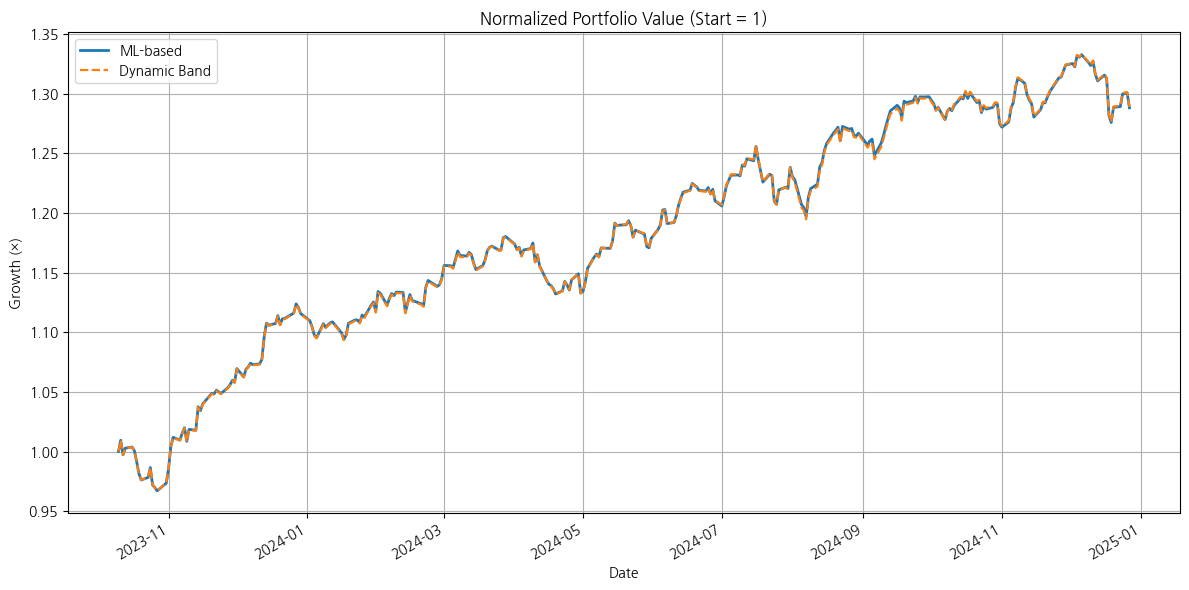

In [ ]:
plt.figure(figsize=(12,6))
for name, ts in aligned.items():
    (ts/ts.iloc[0]).plot(label=name, linewidth=2 if name=="ML-based" else 1.6,
                         linestyle='-' if name=="ML-based" else '--')
plt.title("Normalized Portfolio Value (Start = 1)")
plt.ylabel("Growth (×)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

7-5-4 상대 성과(Active) 진단 & 확대 보기

A) 상대 성과: ML / Dynamic Band 비율(Out/Under-performance)

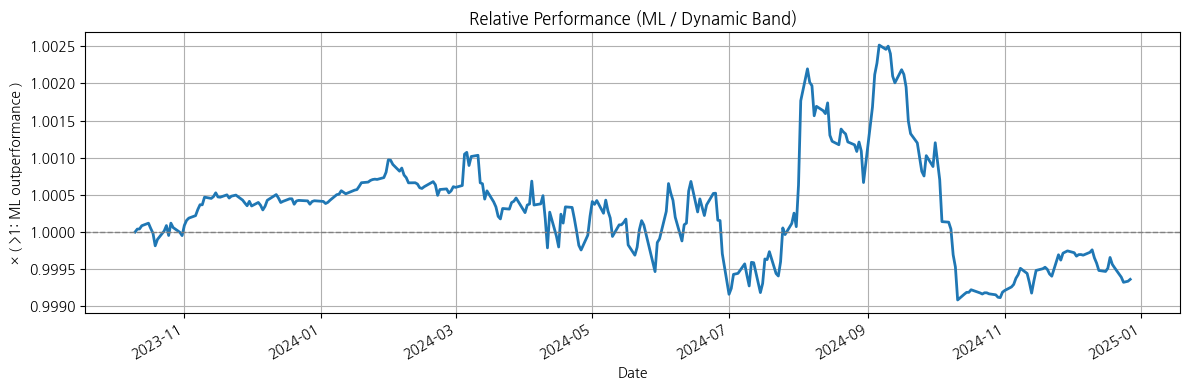

In [ ]:
# 안전하게 대상 확인
if "ML-based" not in aligned or "Dynamic Band" not in aligned:
    raise ValueError("aligned 사전에 'ML-based'와 'Dynamic Band'가 있어야 합니다.")

ml  = aligned["ML-based"]
dyn = aligned["Dynamic Band"]

# (1) '상대 NAV' = ML / DynamicBand (둘 다 1로 정규화 후 비율)
rel = (ml/ml.iloc[0]) / (dyn/dyn.iloc[0])

plt.figure(figsize=(12,4))
rel.plot(linewidth=2)
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.title("Relative Performance (ML / Dynamic Band)")
plt.ylabel("× ( >1: ML outperformance )")
plt.grid(True); plt.tight_layout(); plt.show()

B) 액티브 리턴 & 정보비율(IR)

Active return mean (daily): -0.000002
Active return std  (daily): 0.000191
Information Ratio (≈): -0.185


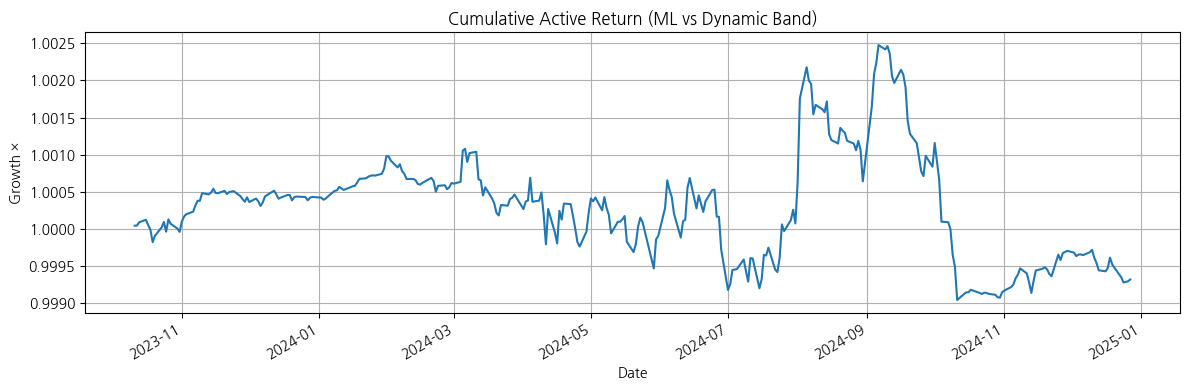

In [ ]:
# (2) 일간 액티브 리턴 = ML일간 - Dynamic일간
daily_ml  = ml.pct_change().dropna()
daily_dyn = dyn.pct_change().dropna()
idx = daily_ml.index.intersection(daily_dyn.index)
active = (daily_ml.loc[idx] - daily_dyn.loc[idx]).dropna()

# 정보비율(IR)
IR = active.mean() / active.std() * np.sqrt(252) if active.std()!=0 else np.nan
cum_excess = (1 + active).cumprod()  # 누적 초과수익(근사)

print(f"Active return mean (daily): {active.mean():.6f}")
print(f"Active return std  (daily): {active.std():.6f}")
print(f"Information Ratio (≈): {IR:.3f}")

plt.figure(figsize=(12,4))
cum_excess.plot()
plt.title("Cumulative Active Return (ML vs Dynamic Band)")
plt.ylabel("Growth ×"); plt.grid(True); plt.tight_layout(); plt.show()

C) 롤링(구간별) 비교: 3개월 초과수익 & 6개월 IR

/tmp/ipython-input-4029933115.py:31: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


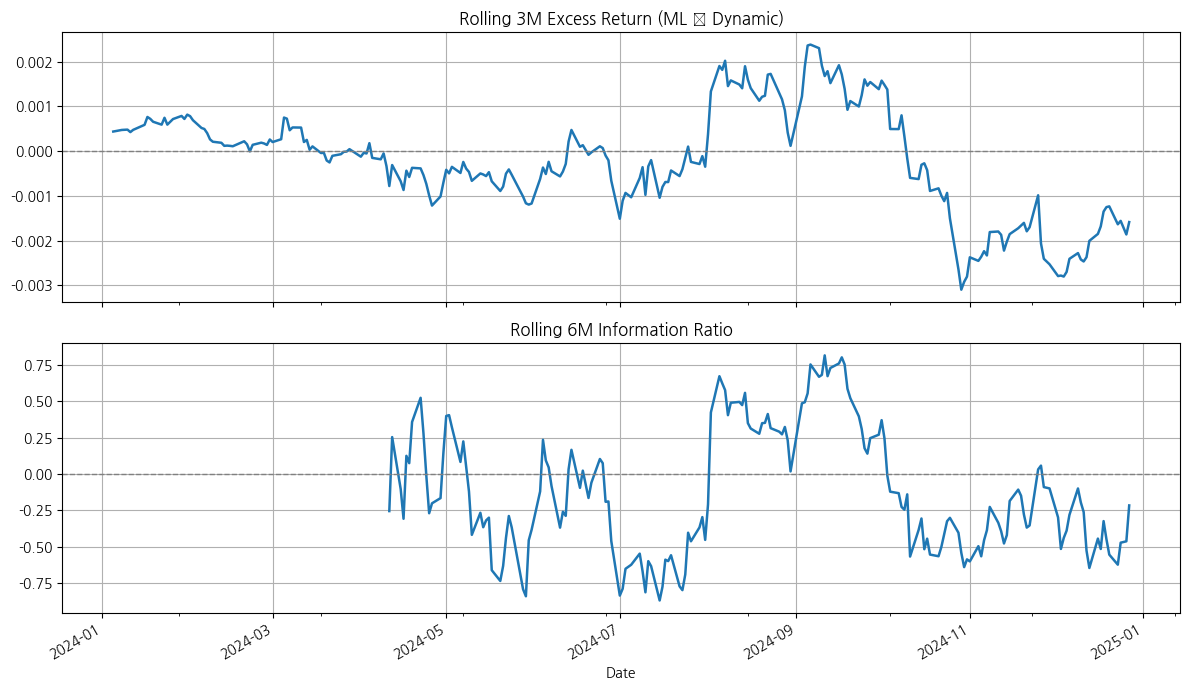

In [ ]:
# 정렬 & 액티브 리턴 산출
daily_ml  = ml.pct_change()
daily_dyn = dyn.pct_change()
active = (pd.concat([daily_ml.rename('ml'), daily_dyn.rename('dyn')], axis=1)
            .dropna())
active = (active['ml'] - active['dyn'])

# 롤링 3개월(60영업일) 초과수익 ― 안정적 계산 권장
roll_excess_60 = np.exp(np.log1p(active).rolling(60).sum()) - 1
# (또는) roll_excess_60 = (1 + active).rolling(60).apply(np.prod, raw=True) - 1

# 롤링 6개월(126영업일) IR
def _roll_ir(x):
    x = pd.Series(x)
    return (x.mean()/x.std())*np.sqrt(252) if x.std() not in (0, np.nan) else np.nan

roll_IR_126 = active.rolling(126).apply(_roll_ir, raw=False)

# 플롯
fig, ax = plt.subplots(2,1, figsize=(12,7), sharex=True)
roll_excess_60.plot(ax=ax[0], linewidth=1.8)
ax[0].axhline(0, color='gray', linestyle='--', linewidth=1)
ax[0].set_title("Rolling 3M Excess Return (ML − Dynamic)")
ax[0].grid(True)

roll_IR_126.plot(ax=ax[1], linewidth=1.8)
ax[1].axhline(0, color='gray', linestyle='--', linewidth=1)
ax[1].set_title("Rolling 6M Information Ratio")
ax[1].grid(True)

plt.tight_layout(); plt.show()

D) 거래비용/신호 요약(있으면 함께)

In [ ]:
try:
    total_cost_ml = float(np.sum(costs_ml))
    yrs_ml = (ml.index[-1] - ml.index[0]).days/365.25
    print(f"ML total cost: ${total_cost_ml:,.2f} / yr: ${total_cost_ml/yrs_ml:,.2f}")
except Exception:
    pass

try:
    # 동적 밴드에 turnovers_dynamic이 있다면 비용 추정
    total_cost_dyn = float(np.sum(turnovers_dynamic))*cost_rate
    yrs_dyn = (dyn.index[-1] - dyn.index[0]).days/365.25
    print(f"Dynamic total cost(approx): ${total_cost_dyn:,.2f} / yr: ${total_cost_dyn/yrs_dyn:,.2f}")
except Exception:
    print("(참고) Dynamic Band의 일별 비용/턴오버 기록이 없으면 위 줄은 생략됩니다.")

ML total cost: $7.60 / yr: $6.25
Dynamic total cost(approx): $10.25 / yr: $8.43
